In [1]:
#Data Pre-Processing
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

!pip install scikit-learn
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("AB_NYC_2019.csv")
# Display basic information about the dataset
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [2]:
# Summary statistics for numerical columns
print(df.describe())


                 id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       38843.000000   
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000           0.00

In [3]:
# Checking unique values in categorical columns
print(df.nunique())

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64


In [4]:
df = df[['neighbourhood_group','reviews_per_month','calculated_host_listings_count', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'availability_365']]
# Handling missing values
df = df.dropna()
# Removing outliers in price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
sf = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


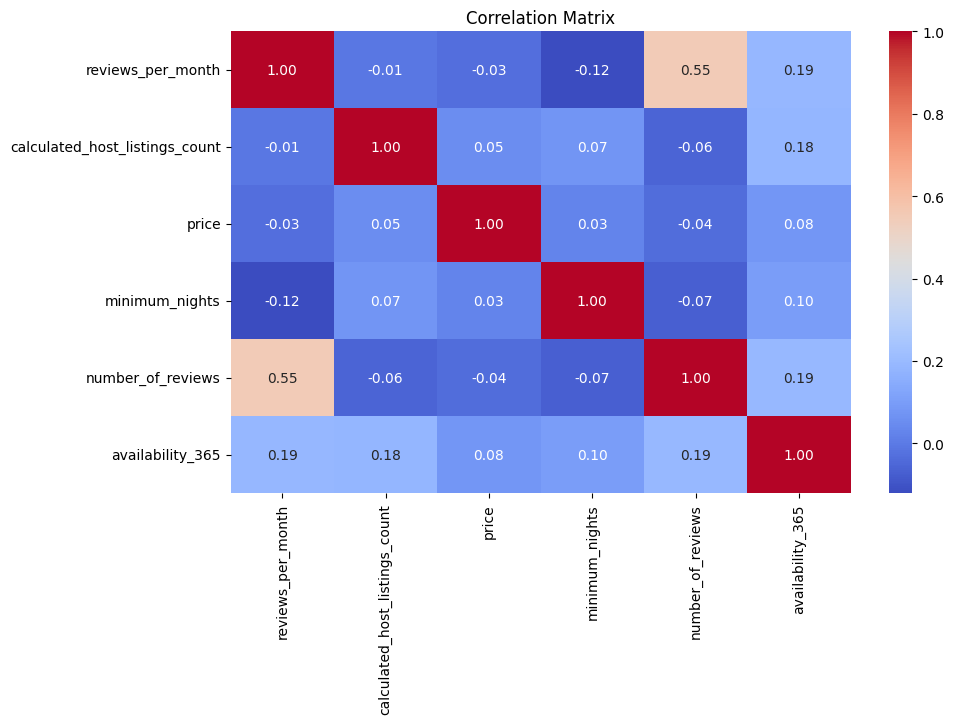

In [6]:
#Correlation Matrix
columns_to_exclude = ['id', 'host_id', 'longitude', 'latitude']
df_filtered = df.drop(columns=[col for col in columns_to_exclude if col in df.columns], errors='ignore')


if 'reviews_per_month' in df_filtered.columns:
    df_filtered['reviews_per_month'] = pd.to_numeric(df_filtered['reviews_per_month'], errors='coerce').fillna(0)

if 'calculated_host_listings_count' in df_filtered.columns:
    df_filtered['calculated_host_listings_count'] = pd.to_numeric(df_filtered['calculated_host_listings_count'], errors='coerce').fillna(0)


correlation_matrix = df_filtered.select_dtypes(include=['number']).corr()

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



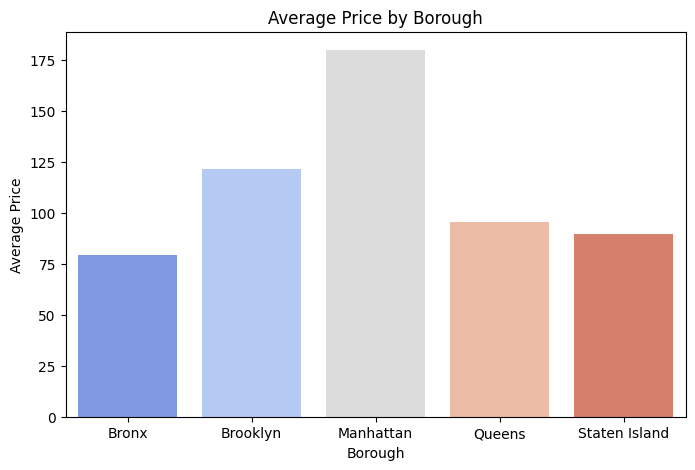

In [7]:
#Exploratory Data Analysis

#Average Price per Borough
plt.figure(figsize=(8,5))
df_grouped = df.groupby('neighbourhood_group')['price'].mean().reset_index()
sns.barplot(x='neighbourhood_group', y='price', data=df_grouped, palette='coolwarm')
plt.title('Average Price by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Price')
plt.show()


<Figure size 1000x600 with 0 Axes>

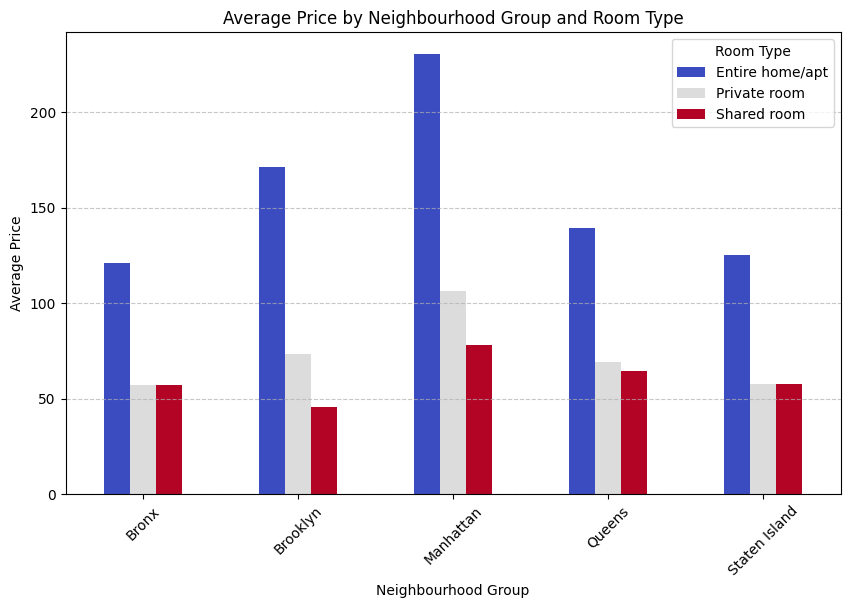

In [8]:
#Bar Chart of Average Price by Neighbourhood Group and Room Type
plt.figure(figsize=(10,6))
df_grouped = df.groupby(['neighbourhood_group', 'room_type'])['price'].mean().unstack()
df_grouped.plot(kind='bar', figsize=(10,6), colormap='coolwarm')

plt.title('Average Price by Neighbourhood Group and Room Type')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.legend(title="Room Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


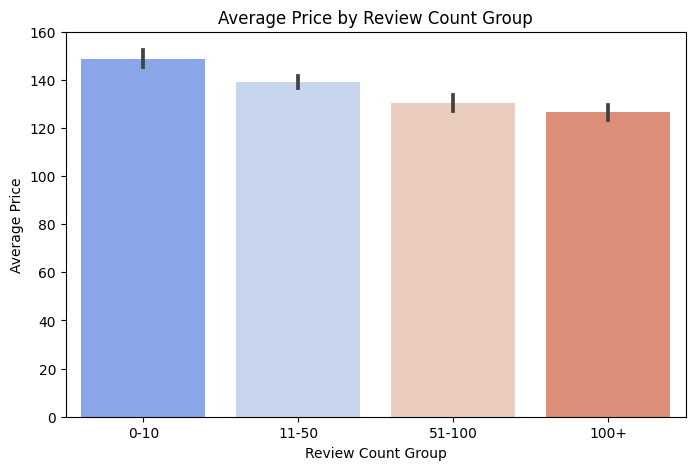

In [9]:
# Plotting bar plot of average price by review count
df['review_group'] = pd.cut(df['number_of_reviews'], bins=[0, 10, 50, 100, 500], labels=['0-10', '11-50', '51-100', '100+'])
plt.figure(figsize=(8,5))
sns.barplot(x='review_group', y='price', data=df, estimator=np.mean, palette='coolwarm')

plt.title('Average Price by Review Count Group')
plt.xlabel('Review Count Group')
plt.ylabel('Average Price')
plt.show()




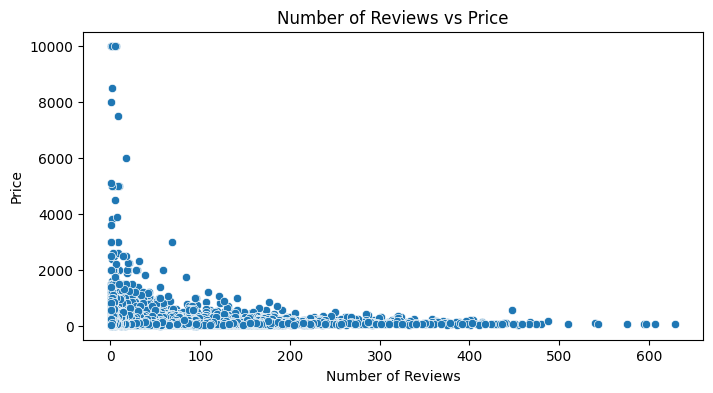

In [10]:
# Scatter plot for number of reviews vs price
plt.figure(figsize=(8,4))
sns.scatterplot(x=df['number_of_reviews'], y=df['price'])
plt.title('Number of Reviews vs Price')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.show()

kmeans_cluster
0    139.283929
1    162.934597
2    128.880043
3    160.316151
Name: price, dtype: float64


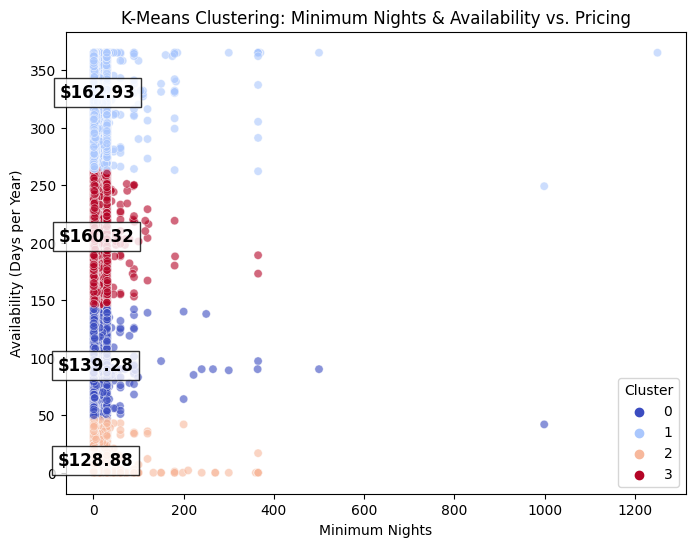

In [11]:
#K-Means clustering
# Selecting features for clustering
X = df[['minimum_nights', 'availability_365']]

# Applying K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  
df['kmeans_cluster'] = kmeans.fit_predict(X)  # Assigning cluster labels

# Calculating the average price per cluster
cluster_avg_price = df.groupby('kmeans_cluster')['price'].mean()
print(cluster_avg_price)  


plt.figure(figsize=(8,6))

# Scatter plot of clusters
sns.scatterplot(x=df['minimum_nights'], y=df['availability_365'], hue=df['kmeans_cluster'], palette='coolwarm', alpha=0.6)
for cluster in cluster_avg_price.index:
    cluster_data = df[df['kmeans_cluster'] == cluster]
    avg_x = np.mean(cluster_data['minimum_nights'])  
    avg_y = np.mean(cluster_data['availability_365'])  
    avg_price = round(cluster_avg_price[cluster], 2)  

    plt.text(avg_x, avg_y, f'${avg_price}', fontsize=12, color='black', weight='bold', ha='center', 
             bbox=dict(facecolor='white', alpha=0.8))

plt.title('K-Means Clustering: Minimum Nights & Availability vs. Pricing')
plt.xlabel('Minimum Nights')
plt.ylabel('Availability (Days per Year)')
plt.legend(title="Cluster")
plt.show()

